In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import feature_engine
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

In [3]:
train_df=pd.read_csv('../data/raw/train.csv')
test_df=pd.read_csv('../data/raw/test.csv')

In [4]:
print(train_df.shape)
print(test_df.shape)

(8693, 14)
(4277, 13)


I want to check the info ,data type and missing values

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [6]:
train_df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [7]:
test_df.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

Missing values in almost every column for both train and test

Are there any duplicates ?

In [8]:
print(train_df.duplicated().sum())
print(test_df.duplicated().sum())

0
0


No duplicates in either train and test

Let's check unique values

In [9]:
print(train_df.nunique())

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64


In [10]:
print(test_df.nunique())

PassengerId     4277
HomePlanet         3
CryoSleep          2
Cabin           3265
Destination        3
Age               79
VIP                2
RoomService      842
FoodCourt        902
ShoppingMall     715
Spa              833
VRDeck           796
Name            4176
dtype: int64


Check if target is balanced

<AxesSubplot:xlabel='Transported', ylabel='count'>

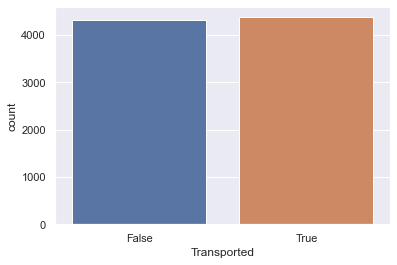

In [11]:
sns.set_theme(style="darkgrid")
sns.countplot(data=train_df,x='Transported')

Text(0.5, 1.0, 'Target distribution')

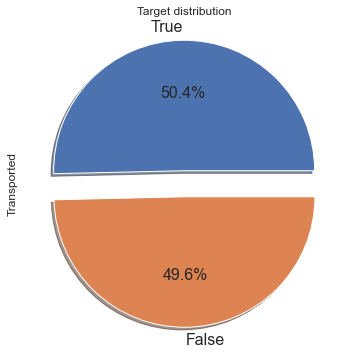

In [12]:
plt.figure(figsize=(6,6))

# Pie plot
train_df['Transported'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Target distribution")

Balanced targets - No sampling techniques required.

Divide columns into continous and categorical columns

In [13]:
numeric_data = train_df.select_dtypes(include=[np.number])
categorical_data = train_df.select_dtypes(exclude=[np.number])

print(numeric_data.shape[1])
print(categorical_data.shape[1])

6
8


Check relation between independent and dependent variables

Text(0.5, 0, 'Age (years)')

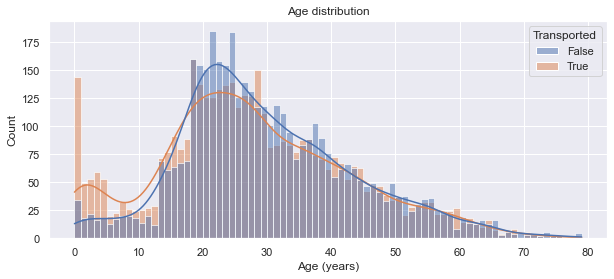

In [14]:
plt.figure(figsize=(10,4))

# Histogram
sns.histplot(data=train_df, x='Age', hue='Transported', binwidth=1, kde=True)

# Aesthetics
plt.title('Age distribution')
plt.xlabel('Age (years)')

0-18 years more likely to be transported,18-25 less likely to be transported ,25-42 can't be defined specifically and then >42 equal chances. Better to create a new feature by binning

Check distribution of the features

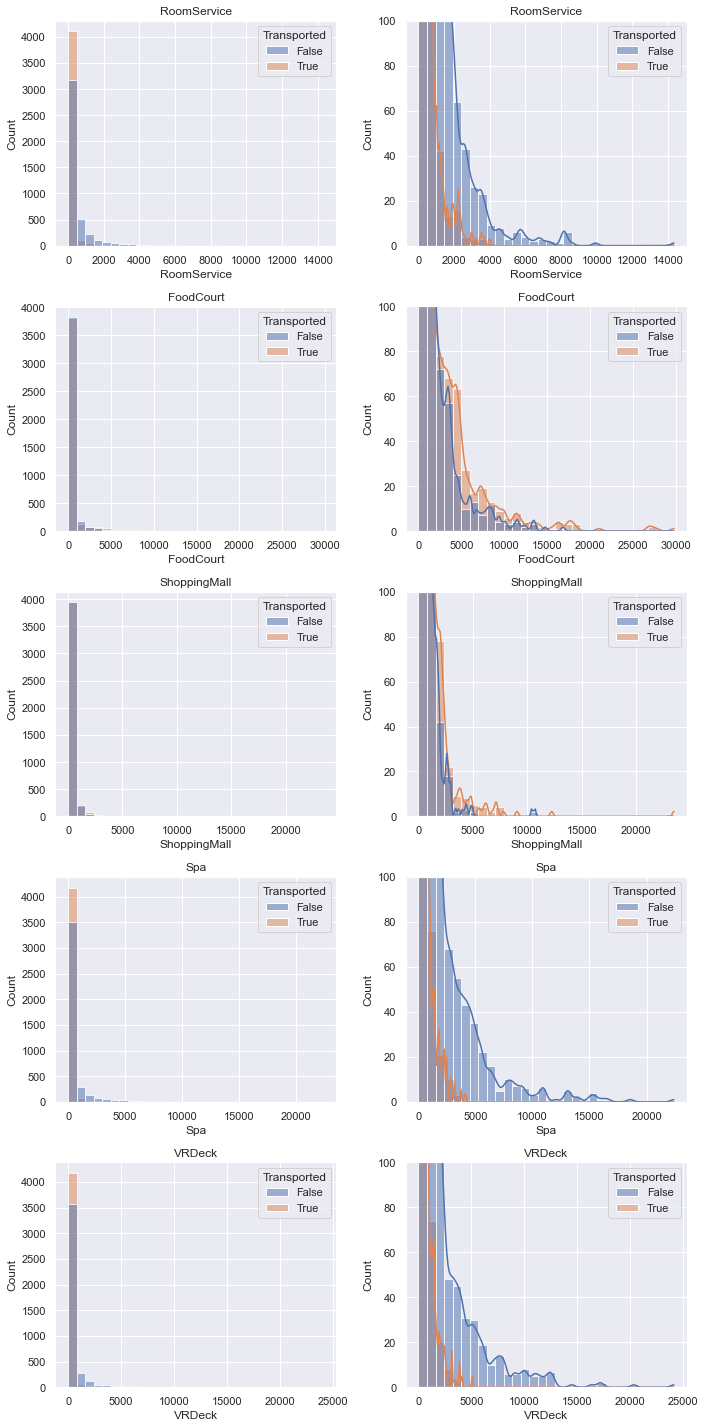

In [15]:
# Expenditure features
exp_feats=numeric_data.columns[1:]

# Plot expenditure features
fig=plt.figure(figsize=(10,20))
for i, var_name in enumerate(exp_feats):
    # Left plot
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=train_df, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var_name)
    
    # Right plot (truncated)
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=train_df, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0,100])
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

- Very few people opted to spend on VRDeck , Spa, FoodCourt , RoomService,Shopping Mall
- Outliers are present in almost all the columns.
- Distribution of VRDeck,RoomService and Spa are different than FoodCourt and ShoppingMall
- People who are transported spend less amount of money

- Skewness should be removed for all the features.
- Create a feature to check if a person has spent or not.

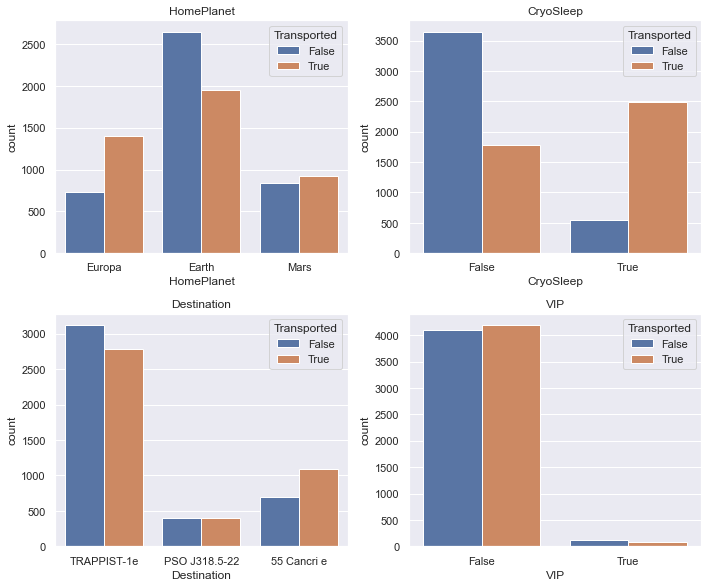

In [16]:
# Categorical features
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Plot categorical features
fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(4,2,i+1)
    sns.countplot(data=train_df, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

- VIP feature distribution seems to be constant variance . This can probably be removed.

Additional categorical features like 'PassengerId', 'Cabin' ,'Name' need to be transformed to a more useful feature if possible.

### FEATURE ENGINEERING

Create a new feature out of Age column

Text(0.5, 1.0, 'Age group distribution')

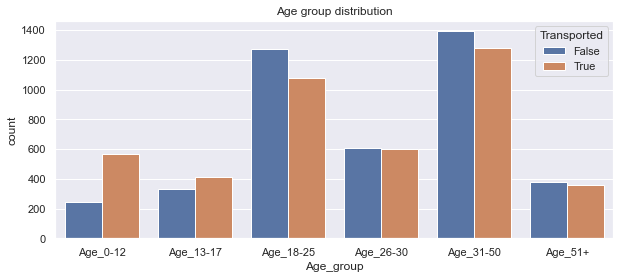

In [17]:
# Training set
train_df['Age_group']=np.nan
train_df.loc[train_df['Age']<=12,'Age_group']='Age_0-12'
train_df.loc[(train_df['Age']>12) & (train_df['Age']<18),'Age_group']='Age_13-17'
train_df.loc[(train_df['Age']>=18) & (train_df['Age']<=25),'Age_group']='Age_18-25'
train_df.loc[(train_df['Age']>25) & (train_df['Age']<=30),'Age_group']='Age_26-30'
train_df.loc[(train_df['Age']>30) & (train_df['Age']<=50),'Age_group']='Age_31-50'
train_df.loc[train_df['Age']>50,'Age_group']='Age_51+'

# New features - test set
test_df['Age_group']=np.nan
test_df.loc[test_df['Age']<=12,'Age_group']='Age_0-12'
test_df.loc[(test_df['Age']>12) & (test_df['Age']<18),'Age_group']='Age_13-17'
test_df.loc[(test_df['Age']>=18) & (test_df['Age']<=25),'Age_group']='Age_18-25'
test_df.loc[(test_df['Age']>25) & (test_df['Age']<=30),'Age_group']='Age_26-30'
test_df.loc[(test_df['Age']>30) & (test_df['Age']<=50),'Age_group']='Age_31-50'
test_df.loc[test_df['Age']>50,'Age_group']='Age_51+'

# Plot distribution of new features
plt.figure(figsize=(10,4))
g=sns.countplot(data=train_df, x='Age_group', hue='Transported', order=['Age_0-12','Age_13-17','Age_18-25','Age_26-30','Age_31-50','Age_51+'])
plt.title('Age group distribution')

Create a total expenditure column and identify passengers with no expense

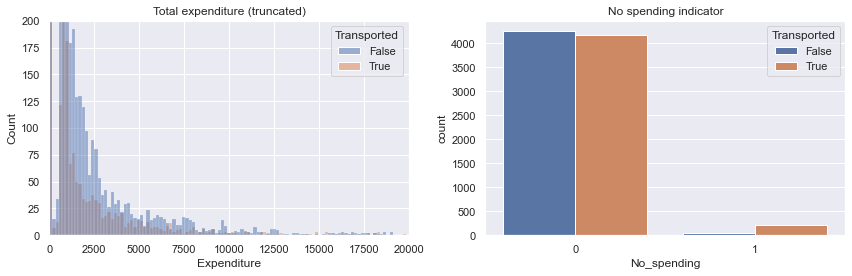

In [18]:
# New features - training set
exp_feats=numeric_data[1:].columns
train_df['Expenditure']=train_df[exp_feats].sum(axis=1)
train_df['No_spending']=(train_df['Expenditure']==0).astype(int)

# New features - test set
test_df['Expenditure']=test_df[exp_feats].sum(axis=1)
test_df['No_spending']=(test_df['Expenditure']==0).astype(int)

# Plot distribution of new features
fig=plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=train_df, x='Expenditure', hue='Transported', bins=200)
plt.title('Total expenditure (truncated)')
plt.ylim([0,200])
plt.xlim([0,20000])

plt.subplot(1,2,2)
sns.countplot(data=train_df, x='No_spending', hue='Transported')
plt.title('No spending indicator')
fig.tight_layout()

Extract passenger group and group size from passenger id

C:\2022\Skills\MachineLearning\Spaceship_Titanic\env\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


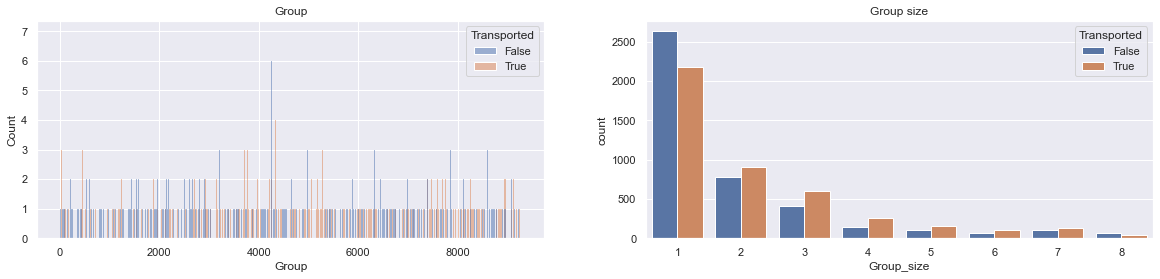

In [19]:
train_df['Group']=train_df['PassengerId'].apply(lambda x:x.split('_')[0]).astype(int)
test_df['Group']=test_df['PassengerId'].apply(lambda x:x.split('_')[0]).astype(int)

# New feature - Group size
train_df['Group_size']=train_df['Group'].map(lambda x: pd.concat([train_df['Group'], test_df['Group']]).value_counts()[x])
test_df['Group_size']=test_df['Group'].map(lambda x: pd.concat([train_df['Group'], test_df['Group']]).value_counts()[x])

# Plot distribution of new features
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
sns.histplot(data=train_df, x='Group', hue='Transported', binwidth=1)
plt.title('Group')

plt.subplot(1,2,2)
sns.countplot(data=train_df, x='Group_size', hue='Transported')
plt.title('Group size')
fig.tight_layout()

We can create a solo group as group size=1 has more counts

(0.0, 3000.0)

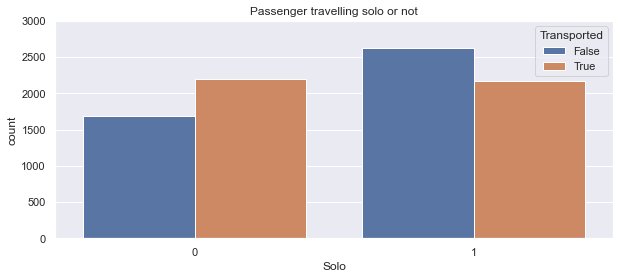

In [20]:
train_df['Solo'] = (train_df['Group_size']==1).astype(int)
test_df['Solo']=(test_df['Group_size']==1).astype(int)

# New feature distribution
plt.figure(figsize=(10,4))
sns.countplot(data=train_df, x='Solo', hue='Transported')
plt.title('Passenger travelling solo or not')
plt.ylim([0,3000])

Extract data from cabin feature

In [21]:
train_df['Cabin'].fillna("Z/9999/Z",inplace=True)
test_df['Cabin'].fillna("Z/9999/Z",inplace=True)
train_df['Cabin_deck']=train_df['Cabin'].apply(lambda x:x.split('/')[0])
train_df['Cabin_number']=train_df['Cabin'].apply(lambda x:x.split('/')[1]).astype(int)
train_df['Cabin_side']=train_df['Cabin'].apply(lambda x:x.split('/')[2])

test_df['Cabin_deck'] = test_df['Cabin'].apply(lambda x: x.split('/')[0])
test_df['Cabin_number'] = test_df['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
test_df['Cabin_side'] = test_df['Cabin'].apply(lambda x: x.split('/')[2])



In [22]:
type(train_df['Cabin_deck']=='Z')
train_df.loc[train_df['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
train_df.loc[train_df['Cabin_number']==9999,'Cabin_number']=np.nan
train_df.loc[train_df['Cabin_side']=='Z', 'Cabin_side']=np.nan

test_df.loc[test_df['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
test_df.loc[test_df['Cabin_number']==9999,'Cabin_number']=np.nan
test_df.loc[test_df['Cabin_side']=='Z', 'Cabin_side']=np.nan

train_df.drop('Cabin',axis=1,inplace=True)
test_df.drop('Cabin',axis=1,inplace=True)

In [23]:
train_df['Cabin_deck'].value_counts()

F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: Cabin_deck, dtype: int64

In [24]:
train_df['Cabin_side'].value_counts()

S    4288
P    4206
Name: Cabin_side, dtype: int64

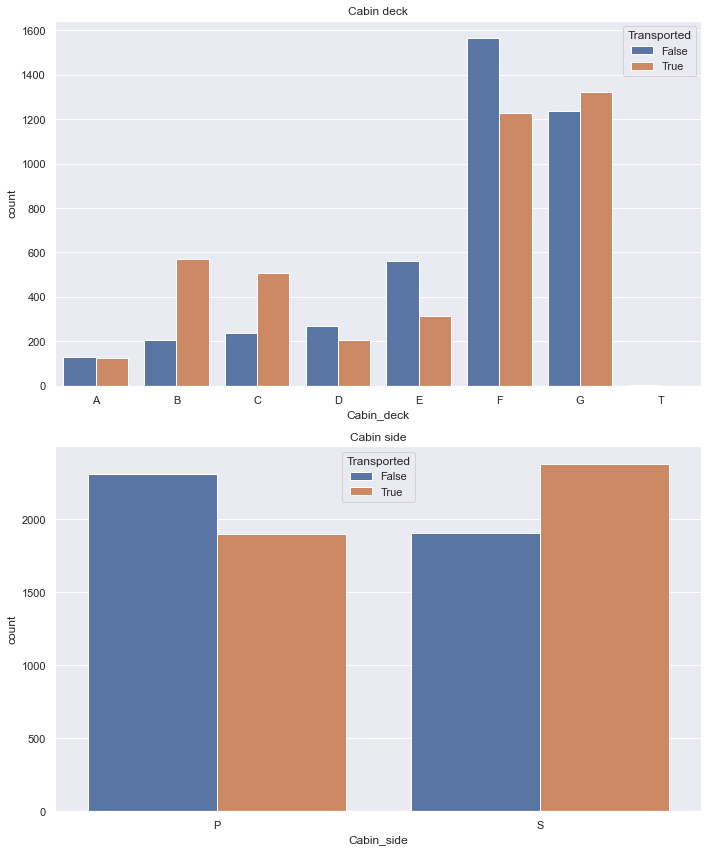

In [25]:
fig=plt.figure(figsize=(10,12))
plt.subplot(2,1,1)
sns.countplot(data=train_df, x='Cabin_deck', hue='Transported', order=['A','B','C','D','E','F','G','T'])
plt.title('Cabin deck')

plt.subplot(2,1,2)
sns.countplot(data=train_df, x='Cabin_side', hue='Transported')
plt.title('Cabin side')
fig.tight_layout()


Extract family size by surname

In [26]:
train_df['Name'].fillna('Unknown Unknown', inplace=True)
test_df['Name'].fillna('Unknown Unknown', inplace=True)

train_df['Surname']=train_df['Name'].str.split().str[-1]
test_df['Surname']=test_df['Name'].str.split().str[-1]




<AxesSubplot:xlabel='Family_size', ylabel='count'>

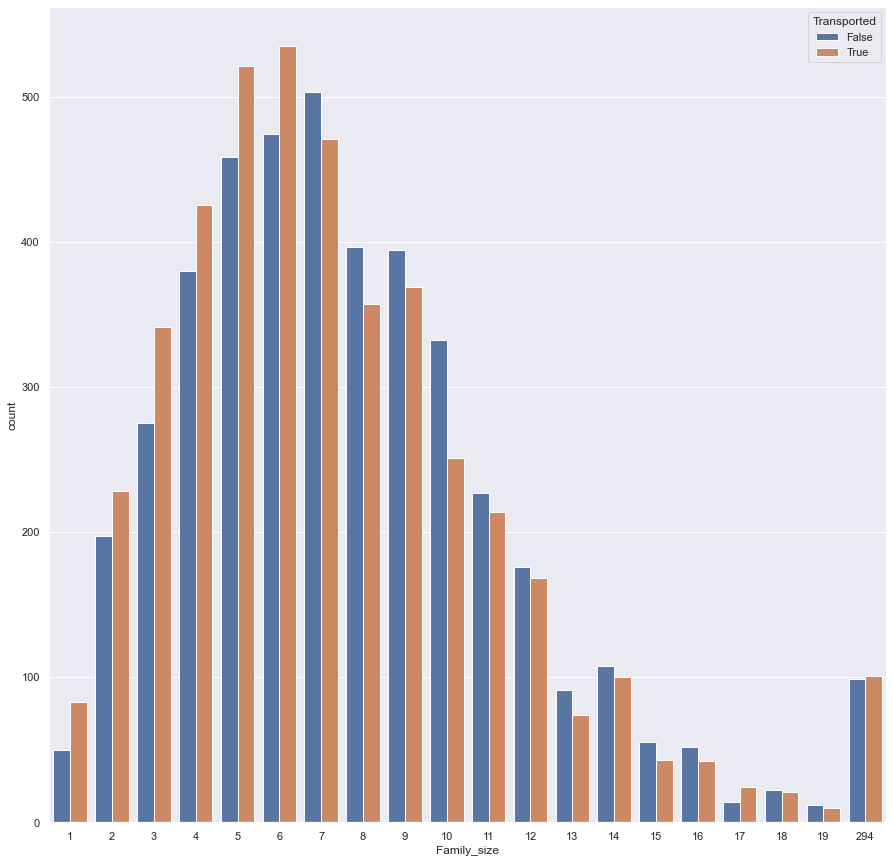

In [27]:
train_df['Family_size']=train_df['Surname'].map(lambda x: pd.concat([train_df['Surname'],test_df['Surname']]).value_counts()[x])
test_df['Family_size']=test_df['Surname'].map(lambda x:pd.concat([train_df['Surname'],test_df['Surname']]).value_counts()[x])

train_df.loc[train_df['Surname']=='Unknown Unknown','Surname']=np.nan
test_df.loc[test_df['Surname']=='Unknown Unknown','Surname']=np.nan

train_df.drop('Name',inplace=True,axis=1)
test_df.drop('Name',inplace=True,axis=1)

plt.figure(figsize=(15,15))
sns.countplot(data=train_df,hue='Transported',x='Family_size')

In [28]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Expenditure,No_spending,Group,Group_size,Solo,Cabin_deck,Cabin_number,Cabin_side,Surname,Family_size
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,39.0,0,1,1,1,B,0.0,P,Ofracculy,3
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,...,760.0,0,2,1,1,F,0.0,S,Vines,4
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,...,10441.0,0,3,2,0,A,0.0,S,Susent,7
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,...,5209.0,0,3,2,0,A,0.0,S,Susent,7
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,...,1107.0,0,4,1,1,F,1.0,S,Santantines,9


Family size found from surname does have correlation with the number of people transported.

CHECK FOR MISSING DATA

In [29]:
y=train_df['Transported'].copy().astype(int)
X=train_df.drop('Transported',axis=1).copy()

data=pd.concat([X,test_df])
data.head().reset_index(drop=True)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Expenditure,No_spending,Group,Group_size,Solo,Cabin_deck,Cabin_number,Cabin_side,Surname,Family_size
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,39.0,0,1,1,1,B,0.0,P,Ofracculy,3
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,...,760.0,0,2,1,1,F,0.0,S,Vines,4
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,...,10441.0,0,3,2,0,A,0.0,S,Susent,7
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,...,5209.0,0,3,2,0,A,0.0,S,Susent,7
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,...,1107.0,0,4,1,1,F,1.0,S,Santantines,9


In [30]:
# Columns with missing values
na_cols=data.columns[data.isna().any()].tolist()
# Missing values summary
mv=pd.DataFrame(data[na_cols].isna().sum(), columns=['Number_missing']).sort_values('Number_missing',ascending=False)
mv['Percentage_missing']=np.round(100*mv['Number_missing']/len(data),2)
mv

,Number_missing,Percentage_missing
CryoSleep,310,2.39
ShoppingMall,306,2.36
Cabin_deck,299,2.31
Cabin_number,299,2.31
Cabin_side,299,2.31
VIP,296,2.28
FoodCourt,289,2.23
HomePlanet,288,2.22
Spa,284,2.19
Destination,274,2.11


Analyze Surname and HomePlanet together

C:\2022\Skills\MachineLearning\Spaceship_Titanic\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Number of unique planets per surname')

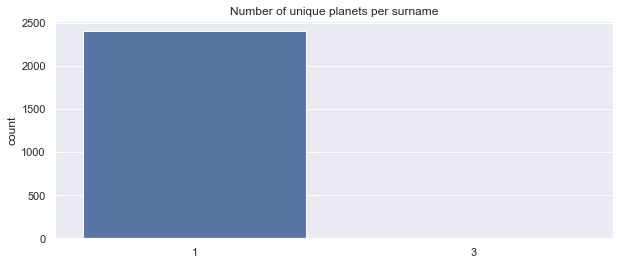

In [31]:
SHP_gb=data.groupby(['Surname','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
SHP_gb.head()
plt.figure(figsize=(10,4))
sns.countplot((SHP_gb>0).sum(axis=1))
plt.title('Number of unique planets per surname')

In [32]:
SHP_gb.index

Index(['Acobson', 'Acobsond', 'Adavisons', 'Adkinson', 'Admingried', 'Aginge',
       'Aginoid', 'Ailled', 'Aillyber', 'Aiming',
       ...
       'Wooterston', 'Workmans', 'Workmanson', 'Wrempeedly', 'Wriggins',
       'Wynneyerson', 'Yanton', 'Yatters', 'Yorkland', 'Youngrayes'],
      dtype='object', name='Surname', length=2401)

In [33]:
SHP_gb.loc[SHP_gb.index=='Acobson','Earth']

Surname
Acobson    5.0
Name: Earth, dtype: float64

<AxesSubplot:>

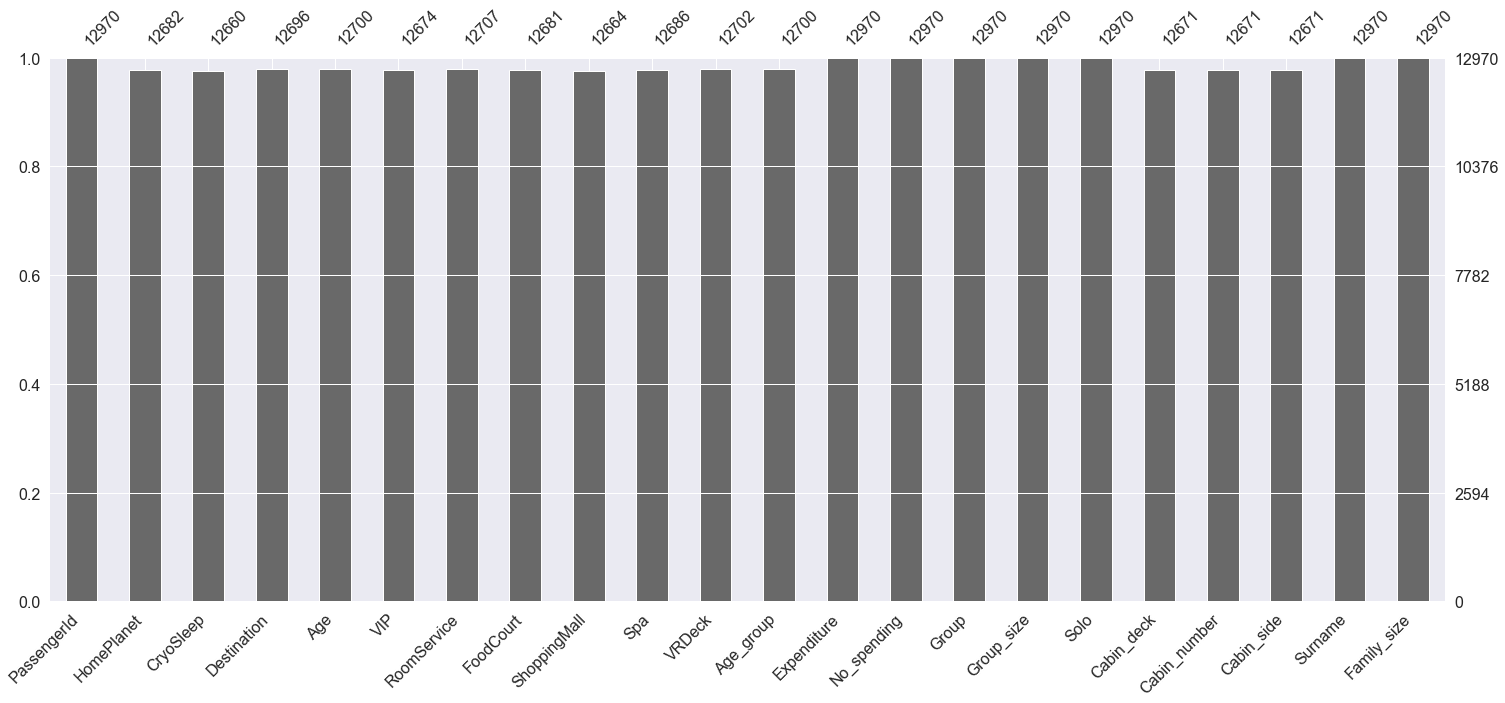

In [34]:
import missingno as msno
msno.bar(data)

<AxesSubplot:>

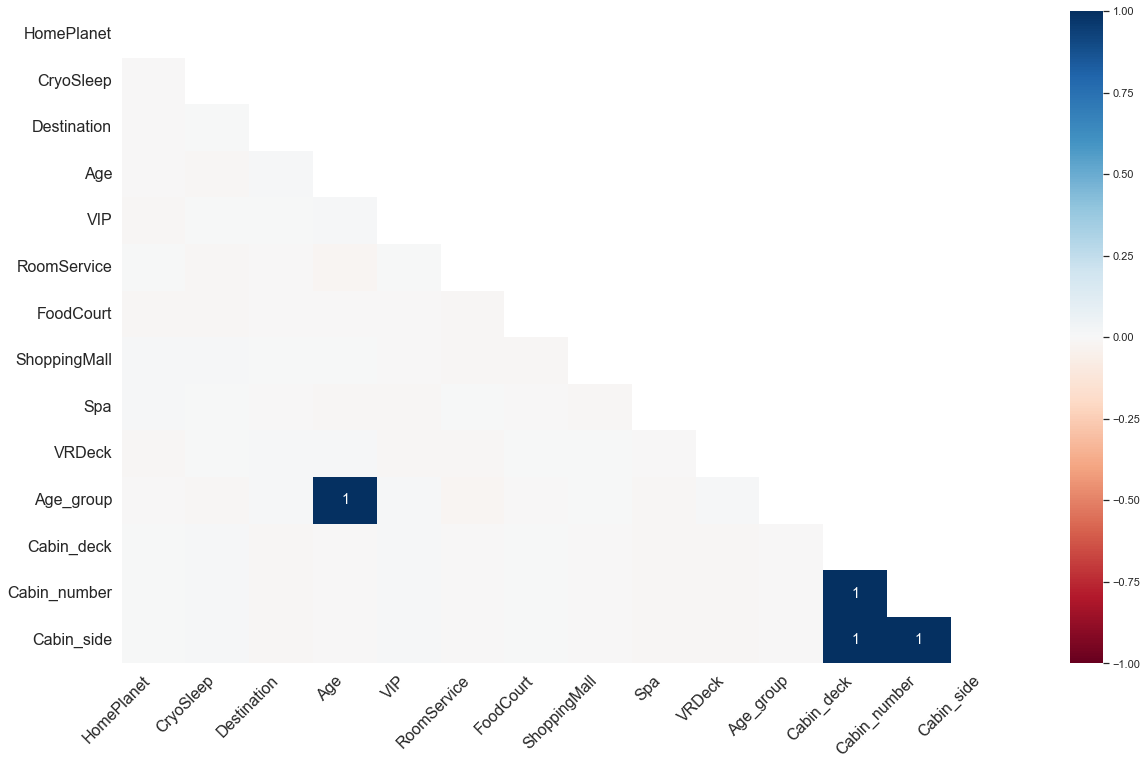

In [35]:
msno.heatmap(data)

No relationship between missing values (Age and age group are related is known)

In [36]:
data.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Age_group', 'Expenditure', 'No_spending', 'Group', 'Group_size',
       'Solo', 'Cabin_deck', 'Cabin_number', 'Cabin_side', 'Surname',
       'Family_size'],
      dtype='object')

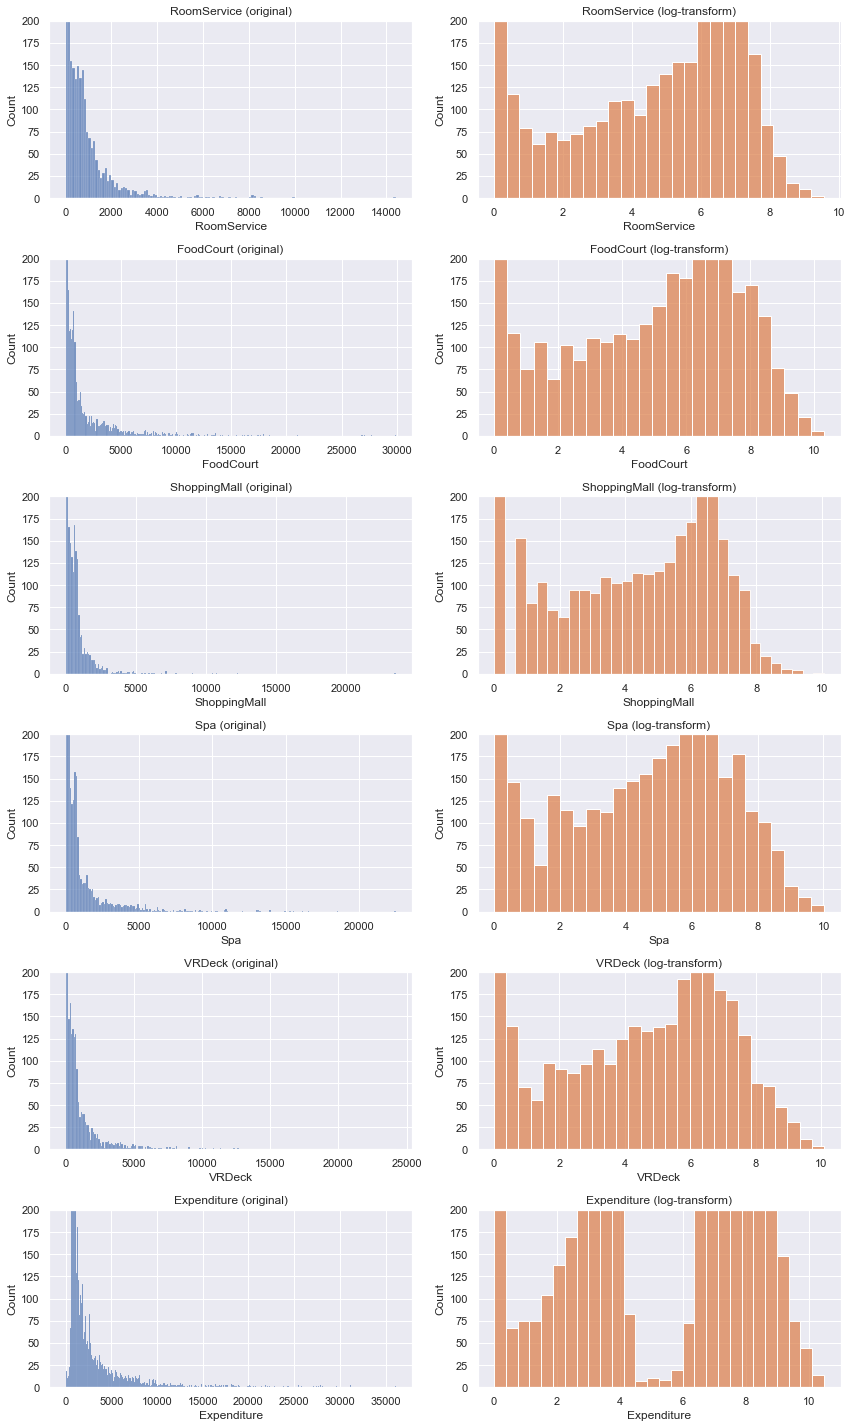

In [37]:
# Plot log transform results
fig=plt.figure(figsize=(12,20))
for i, col in enumerate(['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']):
    plt.subplot(6,2,2*i+1)
    sns.histplot(X[col], binwidth=100)
    plt.ylim([0,200])
    plt.title(f'{col} (original)')
  
    plt.subplot(6,2,2*i+2)
    sns.histplot(np.log(1+X[col]), color='C1')
    plt.ylim([0,200])
    plt.title(f'{col} (log-transform)')
    
fig.tight_layout()
plt.show()

In [38]:
# Train and test
X=data[data['PassengerId'].isin(train_df['PassengerId'].values)].copy()
X_test=data[data['PassengerId'].isin(test_df['PassengerId'].values)].copy()
# Drop qualitative/redundant/collinear/high cardinality features
X.drop(['PassengerId', 'Group', 'Group_size', 'Age_group', 'Cabin_number'], axis=1, inplace=True)
X_test.drop(['PassengerId', 'Group', 'Group_size', 'Age_group', 'Cabin_number'], axis=1, inplace=True)

In [39]:
for col in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']:
    X[col]=np.log(1+X[col])
    X_test[col]=np.log(1+X_test[col])

In [40]:

features=['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']
X[features].skew()

RoomService     1.117736
FoodCourt       1.110788
ShoppingMall    1.201576
Spa             1.090025
VRDeck          1.160167
Expenditure    -0.377042
dtype: float64

In [41]:
X.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Expenditure',
       'No_spending', 'Solo', 'Cabin_deck', 'Cabin_side', 'Surname',
       'Family_size'],
      dtype='object')

In [42]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Destination   8511 non-null   object 
 3   Age           8514 non-null   float64
 4   VIP           8490 non-null   object 
 5   RoomService   8512 non-null   float64
 6   FoodCourt     8510 non-null   float64
 7   ShoppingMall  8485 non-null   float64
 8   Spa           8510 non-null   float64
 9   VRDeck        8505 non-null   float64
 10  Expenditure   8693 non-null   float64
 11  No_spending   8693 non-null   int32  
 12  Solo          8693 non-null   int32  
 13  Cabin_deck    8494 non-null   object 
 14  Cabin_side    8494 non-null   object 
 15  Surname       8693 non-null   object 
 16  Family_size   8693 non-null   int64  
dtypes: float64(7), int32(2), int64(1), object(7)
memory usage: 1.1+ MB


In [43]:
numeric_data = X.select_dtypes(include=[np.number])
categorical_data = X.select_dtypes(exclude=[np.number])

print(numeric_data.shape[1])
print(categorical_data.shape[1])

#final_df=pd.concat([numeric_data,categorical_data], axis=1)

10
7


In [44]:
numeric_data.isna().sum()

Age             179
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Expenditure       0
No_spending       0
Solo              0
Family_size       0
dtype: int64

In [45]:
numeric_data.skew()

Age             0.419097
RoomService     1.117736
FoodCourt       1.110788
ShoppingMall    1.201576
Spa             1.090025
VRDeck          1.160167
Expenditure    -0.377042
No_spending     5.440584
Solo           -0.212195
Family_size     6.300315
dtype: float64

In [46]:
from feature_engine.imputation import MeanMedianImputer
median_imputer = MeanMedianImputer(imputation_method='median')
# fit the imputer
X_imputed=median_imputer.fit_transform(numeric_data)
X_imputed.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Expenditure,No_spending,Solo,Family_size
0,39.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.688879,0,1,3
1,24.0,4.700480,2.302585,3.258097,6.309918,3.806662,6.634633,0,1,4
2,58.0,3.784190,8.182280,0.000000,8.812248,3.912023,9.253591,0,0,7
3,33.0,0.000000,7.157735,5.918894,8.110728,5.267858,8.558335,0,0,7
4,16.0,5.717028,4.262680,5.023881,6.338594,1.098612,7.010312,0,1,9


In [47]:
X_imputed.skew()

Age             0.431102
RoomService     1.149866
FoodCourt       1.143177
ShoppingMall    1.238498
Spa             1.122324
VRDeck          1.193417
Expenditure    -0.377042
No_spending     5.440584
Solo           -0.212195
Family_size     6.300315
dtype: float64

In [48]:
corr = X_imputed.corr()
# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

C:\Temp\ipykernel_18012\2263219281.py:6: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  (corr


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Expenditure,No_spending,Solo,Family_size
Age,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
RoomService,0.12,nan,nan,nan,nan,nan,nan,nan,nan,nan
FoodCourt,0.20,0.09,nan,nan,nan,nan,nan,nan,nan,nan
ShoppingMall,0.09,0.36,0.10,nan,nan,nan,nan,nan,nan,nan
Spa,0.18,0.15,0.42,0.16,nan,nan,nan,nan,nan,nan
VRDeck,0.16,0.09,0.46,0.10,0.38,nan,nan,nan,nan,nan
Expenditure,0.40,0.49,0.62,0.47,0.60,0.58,nan,nan,nan,nan
No_spending,-0.25,-0.11,-0.12,-0.11,-0.12,-0.11,-0.40,nan,nan,nan
Solo,0.13,0.10,0.01,0.12,0.04,0.03,0.17,-0.14,nan,nan
Family_size,-0.02,0.01,-0.01,0.00,-0.01,-0.01,-0.01,0.01,-0.02,nan


Expenditure column can be dropped due to high correlation .

In [49]:
X_imputed.drop('Expenditure',inplace=True,axis=1)

SCALE

In [55]:
from sklearn import preprocessing
scaler = preprocessing.MaxAbsScaler()
numeric_data_scaled=scaler.fit_transform(X_imputed)
numeric_data_imputed_df=pd.DataFrame(numeric_data_scaled,columns=X_imputed.columns)
numeric_data_imputed_df.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,No_spending,Solo,Family_size
0,0.493671,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.010204
1,0.303797,0.491170,0.223493,0.323723,0.629907,0.377219,0.0,1.0,0.013605
2,0.734177,0.395423,0.794185,0.000000,0.879710,0.387660,0.0,0.0,0.023810
3,0.417722,0.000000,0.694741,0.588099,0.809679,0.522016,0.0,0.0,0.023810
4,0.202532,0.597392,0.413743,0.499171,0.632770,0.108866,0.0,1.0,0.030612


In [56]:
numeric_data_imputed_df.skew()

Age             0.431102
RoomService     1.149866
FoodCourt       1.143177
ShoppingMall    1.238498
Spa             1.122324
VRDeck          1.193417
No_spending     5.440584
Solo           -0.212195
Family_size     6.300315
dtype: float64

In [50]:
categorical_data.isna().sum()

HomePlanet     201
CryoSleep      217
Destination    182
VIP            203
Cabin_deck     199
Cabin_side     199
Surname          0
dtype: int64

In [51]:
from feature_engine.imputation import CategoricalImputer
imputer = CategoricalImputer()
CategoricalImputer(fill_value='frequent',return_object=False)
categorical_data=imputer.fit_transform(categorical_data)

In [78]:
categorical_data.isna().sum()

HomePlanet     0
CryoSleep      0
Destination    0
VIP            0
Cabin_deck     0
Cabin_side     0
Surname        0
dtype: int64

Encoding

In [54]:
from feature_engine.encoding import CountFrequencyEncoder
encoder = CountFrequencyEncoder(encoding_method='frequency',
                         )
categorical_data=encoder.fit_transform(categorical_data)

In [77]:
categorical_data.head()

,HomePlanet,CryoSleep,Destination,VIP,Cabin_deck,Cabin_side,Surname
0,0.245140,0.625676,0.680433,0.953756,0.089612,0.483838,0.000115
1,0.529391,0.625676,0.680433,0.953756,0.321408,0.493270,0.000460
2,0.245140,0.625676,0.680433,0.022892,0.029449,0.493270,0.000690
3,0.245140,0.625676,0.680433,0.953756,0.029449,0.493270,0.000690
4,0.529391,0.625676,0.680433,0.953756,0.321408,0.493270,0.000690


In [57]:
final_df=pd.concat([numeric_data_imputed_df,categorical_data], axis=1)
final_df.shape

(8693, 16)

In [58]:
final_df.head(2)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,No_spending,Solo,Family_size,HomePlanet,CryoSleep,Destination,VIP,Cabin_deck,Cabin_side,Surname
0,0.493671,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.010204,0.245140,0.625676,0.680433,0.953756,0.089612,0.483838,0.000115
1,0.303797,0.49117,0.223493,0.323723,0.629907,0.377219,0.0,1.0,0.013605,0.529391,0.625676,0.680433,0.953756,0.321408,0.493270,0.000460


In [61]:
corr = final_df.corr()
# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

C:\Temp\ipykernel_18012\375436262.py:6: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  (corr


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,No_spending,Solo,Family_size,HomePlanet,CryoSleep,Destination,VIP,Cabin_deck,Cabin_side
Age,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
RoomService,0.12,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
FoodCourt,0.20,0.09,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
ShoppingMall,0.09,0.36,0.10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Spa,0.18,0.15,0.42,0.16,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
VRDeck,0.16,0.09,0.46,0.10,0.38,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
No_spending,-0.25,-0.11,-0.12,-0.11,-0.12,-0.11,nan,nan,nan,nan,nan,nan,nan,nan,nan
Solo,0.13,0.10,0.01,0.12,0.04,0.03,-0.14,nan,nan,nan,nan,nan,nan,nan,nan
Family_size,-0.02,0.01,-0.01,0.00,-0.01,-0.01,0.01,-0.02,nan,nan,nan,nan,nan,nan,nan
HomePlanet,-0.18,-0.07,-0.07,-0.01,-0.06,-0.02,0.03,0.22,0.02,nan,nan,nan,nan,nan,nan


In [60]:
#Dropping surname 
final_df.drop('Surname',inplace=True,axis=1)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(final_df, y, test_size=0.33, random_state=42)

In [79]:
type(y)

pandas.core.series.Series

DOING A BASELINE TEST

In [63]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

In [71]:
def model_fit(x_train, x_test, y_train, y_test):
    
    #LogisticRegression
    LR = LogisticRegression(solver='liblinear', C = 0.01)
    LR.fit(x_train, y_train)
    print('1.LogisticRegression score (test) :', LR.score(x_test, y_test))
             
    #RandomForestClassifier
    RFC = RandomForestClassifier(n_estimators = 140, max_depth = 9)
    RFC.fit(x_train, y_train)
    print('2.RandomForestClassifier score (test) :', RFC.score(x_test, y_test))
          
    #DecisionTreeClassifier
    DTC = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3)
    DTC.fit(x_train,y_train)
    print('3.DecisionTreeClassifier score (test) :', DTC.score(x_test, y_test))
    
    #KNeighborsClassifier
    KNC = KNeighborsClassifier(n_neighbors = 5)
    KNC.fit(x_train, y_train)
    print('4.KNeighborsClassifier score (test) :', KNC.score(x_test, y_test))
          
    #SVC for linear
    from sklearn.svm import LinearSVC
    SVC_linear = LinearSVC(C = 0.1)
    SVC_linear.fit(x_train, y_train)
    print('5. SVC for linear score (test) :', SVC_linear.score(x_test, y_test))
          
    #SVC for rbf
    from sklearn.svm import SVC
    SVC_rbf = SVC(kernel='rbf', C = 10, gamma = 0.01)
    SVC_rbf.fit(x_train, y_train)
    print('6. SVC for rbf score (test) :', SVC_rbf.score(x_test, y_test))
    
    GBR = GradientBoostingClassifier(learning_rate=0.01, max_depth= 6,
                                min_samples_leaf=1,n_estimators=450, random_state = 30,subsample = 0.2).fit(x_train, y_train)
    print('7. GradientBoostingClassifier :', GBR.score(x_test, y_test))
    
    XG =XGBClassifier(objective = 'binary:logistic' , learning_rate = 0.01, use_label_encoder=False,
                max_depth = 10, alpha = 10, n_estimators = 10).fit(x_train, y_train)
    print('8. XGBClassifier :', XG.score(x_test, y_test))
    model = CatBoostClassifier(random_state=50, 
                         loss_function='CrossEntropy',
                         use_best_model=True,iterations=100, learning_rate=0.1)
    model.fit(x_train,y_train, eval_set=(x_test, y_test), verbose=0, plot=True)
    print('9. CatBoostClassifier:', model.score(x_test, y_test))
    lgbm = LGBMClassifier(random_state=50, 
                         loss_function='CrossEntropy',
                         use_best_model=True,iterations=100, learning_rate=0.1)
    lgbm.fit(x_train,y_train, eval_set=(x_test, y_test), verbose=0)
    print('10. LightGBMClassifier:', lgbm.score(x_test, y_test))
    
    return [LR, RFC, DTC, KNC, SVC_linear, SVC_rbf, GBR, XG, model,lgbm]

1.LogisticRegression score (test) : 0.7601951899616591
2.RandomForestClassifier score (test) : 0.7873823631927501
3.DecisionTreeClassifier score (test) : 0.7197629836179854
4.KNeighborsClassifier score (test) : 0.7598466364586964
5. SVC for linear score (test) : 0.7594980829557337
6. SVC for rbf score (test) : 0.7682119205298014
7. GradientBoostingClassifier : 0.7873823631927501
[15:52:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
8. XGBClassifier : 0.7790170791216452


C:\2022\Skills\MachineLearning\Spaceship_Titanic\env\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

9. CatBoostClassifier: 0.7849424886720111
[LightGBM] [Warning] Unknown parameter: loss_function
[LightGBM] [Warning] Unknown parameter: use_best_model
[LightGBM] [Warning] Unknown parameter: iterations


C:\2022\Skills\MachineLearning\Spaceship_Titanic\env\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


10. LightGBMClassifier: 0.7922621122342279


C:\2022\Skills\MachineLearning\Spaceship_Titanic\env\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


<AxesSubplot:title={'center':'The Score in Nine ML Model'}, xlabel='Score', ylabel='ML Model'>

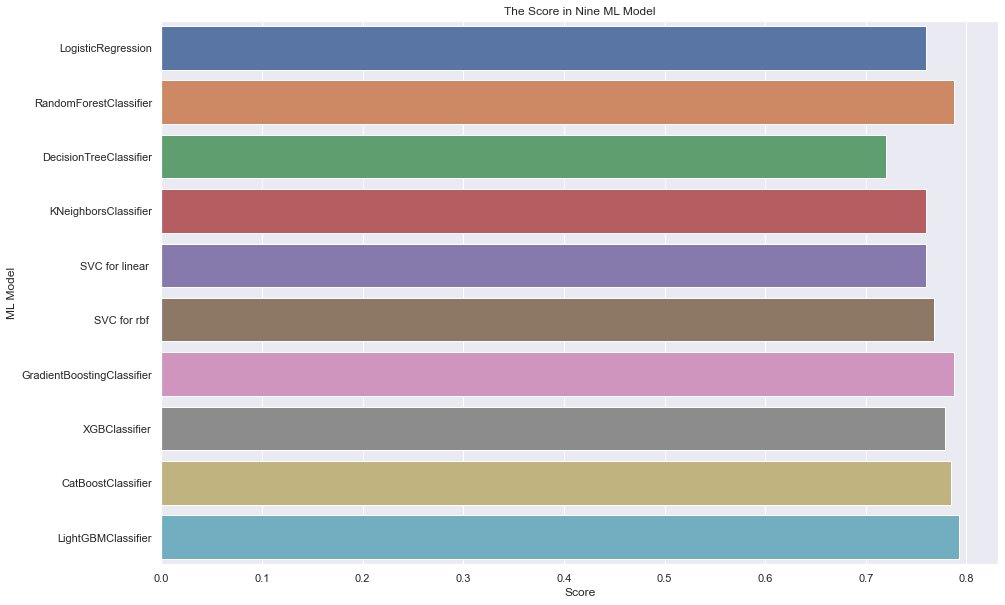

In [72]:
Model=[]
Model=model_fit(X_train, X_test, y_train, y_test)
ML_model = ['LogisticRegression', 'RandomForestClassifier', 'DecisionTreeClassifier', 'KNeighborsClassifier', 
            'SVC for linear ', 'SVC for rbf ', 'GradientBoostingClassifier', 'XGBClassifier', 'CatBoostClassifier','LightGBMClassifier']
score_num = []
for i in range(10):
  score_num.append(Model[i].score(X_test, y_test))

plt.figure(figsize = (15, 10))
plt.xlabel('Score')
plt.ylabel('ML Model')
plt.title('The Score in Nine ML Model')
sns.barplot(x = score_num, y = ML_model)